In [69]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### 웹 연구 (Web Research) Team 도구

In [70]:
from typing import List
from langchain_community.document_loaders import WebBaseLoader
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool


tavily_tool = TavilySearch(max_results=2)                       # 검색 도구 정의(TavilySearch)


@tool
def scrape_webpages(urls: List[str]) -> str:                    # 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
    """Use requests and bs4 to scrape the provided web pages for detailed information."""

    # 주어진 URL 목록을 사용하여 웹 페이지 로드
    loader = WebBaseLoader(                                     
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    
    docs = loader.load()

    doc_list = []

    for doc in docs:
        doc_list.append(f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>')
        

    # 로드된 문서의 제목과 내용을 포함한 문자열 생성
    return "\n\n".join(doc_list)

In [71]:
scraped_data = scrape_webpages.invoke({'urls': ["https://www.khan.co.kr/article/202504041551001"]})

In [72]:
scraped_data

'<Document name="[단독] 한덕수·노태악 통화, 6월3일 대통령 선거일 지정 가닥 - 경향신문">\n\n\n\n\n\n\n\n\n\n\n\n[단독] 한덕수·노태악 통화, 6월3일 대통령 선거일 지정 가닥 - 경향신문\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n레이어 닫기\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n전체\n\n\n\n\n검색창 열기\n\n\n검색창 닫기\n\n\n\n경향신문\n\n\n\n정치\n\n\n\n\n#윤석열 파면\n\n\n\n\n\n\n\n공유하기\n\n\n\n페이스북 공유하기\n\n\n트위터 공유하기\n\n\n카카오톡 공유하기\n\n\n\n밴드 공유하기\n\n\n네이버블로그 공유하기\n\n\nURL복사\n\n\n이메일로 공유하기\n\n\n\n\n\n뉴스플리\n\n\n댓글\n\n\n\n\n\n\n\n\n 한덕수·노태악 통화, 6월3일 대통령 선거일 지정 가닥\n\n\n\n읽음\n\n\n\n\n닫기\n\n\n\n\n\n\n\n\n\n\n\n\n\n검색\n\n\n\n\n\n\n\n\n\n\n\n\n\n경향닷컴 홈으로 이동\n\n전체 메뉴\n\n\n\n최신기사\n\n\n실시간 랭킹 기사\n\n\n\n오피니언\n\n\n\n사설\n\n\n여적\n\n\n기자메모\n\n\n칼럼\n\n\n만평\n\n\n독자마당\n\n\n\n\n\n정치\n\n\n\n대통령실\n\n\n국회·정당\n\n\n국방·외교\n\n\n북한·한반도\n\n\n선거\n\n\n정치 일반\n\n\n\n\n\n경제\n\n\n\n금융·재테크\n\n\n산업\n\n\nIT·가전\n\n\n부동산\n\n\n자동차\n\n\n생활경제\n\n\n취업·창업\n\n\n경제 일반\n\n\n\n\n\n사회\n\n\n

In [73]:
from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # 노드 생성 함수
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# LLM 초기화
llm = ChatOpenAI(model='gpt-4o', temperature=0)

# Agent Factory 인스턴스 생성
agent_factory = AgentFactory('gpt-4o')

### 검색 에이전트

In [74]:
# 에이전트 정의
search_agent = create_react_agent(llm, tools=[tavily_tool])

# 에이전트 노드 생성
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

In [75]:
state_search = {'messages': HumanMessage(content='대구 교보문고', name='Searcher')}

In [76]:
search_node(state_search)

{'messages': [HumanMessage(content='대구 교보문고 대구점은 대구광역시 중구 동성로에 위치한 대형 서점입니다. 이곳은 대구의 중심가인 동성로에 자리 잡고 있으며, 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 보유하고 있습니다. 교보문고 대구점은 대구를 대표하는 서점이자 열린 문화공간으로, 다양한 문화 행사가 열리는 문화 이벤트홀과 어린이 독자들을 위한 키즈가든 등을 갖추고 있습니다.\n\n교보문고 대구점의 주소는 대구광역시 중구 국채보상로 586이며, 영업시간은 매일 오전 10시부터 오후 10시까지입니다. 이곳은 대구의 주요 상업 지역에 위치해 있어 시내 구경과 함께 방문하기에 좋습니다. 또한, B1층에는 핫트랙스가 있어 다양한 상품을 구경할 수 있습니다.\n\n자세한 정보는 [교보문고 대구점 홈페이지](http://www.kyobobook.co.kr/storen/MainStore.laf?SITE=04)에서 확인할 수 있습니다.', additional_kwargs={}, response_metadata={}, name='Searcher')]}

In [77]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


# 웹 연구 (Web Research) Team Supervisor
def create_team_supervisor(model_name, system_prompt, members) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members

    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]


    # # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))


    # # LLM 초기화
    llm = ChatOpenAI(model=model_name, temperature=0)

    # # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

In [78]:
supervisor_agent = create_team_supervisor(
    'gpt-4o',
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

state = {
        "messages": [
            HumanMessage(
                content="대구 교보문고에 대해서 알려줘" 
            )
        ]
    }

supervisor_agent.invoke(state)

RouteResponse(next='Searcher')

In [79]:
import operator
from typing import List, TypedDict
from typing_extensions import Annotated

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


class ResearchState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]        # 메시지
    team_members: List[str]                                     # 멤버 에이전트 목록
    next: str                                                   # Supervisor 에이전트에게 다음 작업자를 선택하도록 지시


llm = ChatOpenAI(model='gpt-4o', temperature=0)


# 검색 노드 생성
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")


# 웹 스크래핑 노드 생성
web_scraping_agent = create_react_agent(llm, tools=[scrape_webpages])
web_scraping_node = agent_factory.create_agent_node(web_scraping_agent, name="WebScraper")


# Supervisor 에이전트 생성
supervisor_agent = create_team_supervisor(
    'gpt-4o-mini',
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

In [80]:
def get_next_node(x):
    return x["next"]

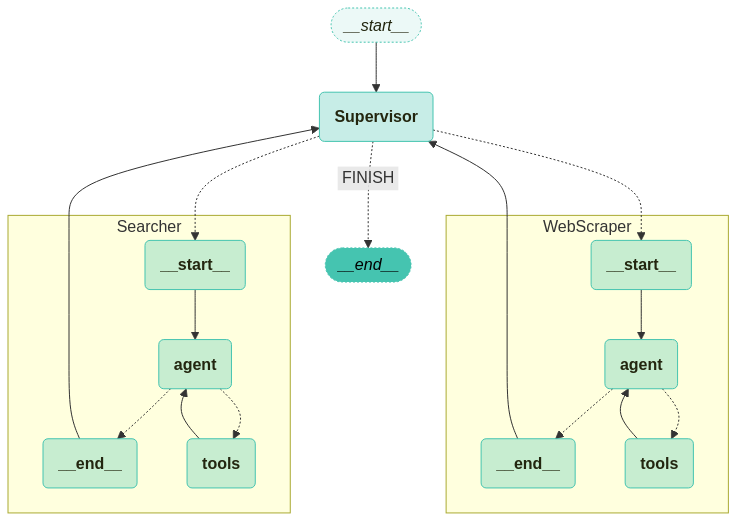

In [81]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
web_research_graph = StateGraph(ResearchState)

# 노드 추가
web_research_graph.add_node("Searcher", search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("Supervisor", supervisor_agent)

# 엣지 추가
web_research_graph.add_edge("Searcher", "Supervisor")
web_research_graph.add_edge("WebScraper", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
web_research_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {"Searcher": "Searcher", "WebScraper": "WebScraper", "FINISH": END},
)

# 시작 노드 설정
web_research_graph.set_entry_point("Supervisor")

# 그래프 컴파일
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(web_research_app, xray=True)

In [82]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig


def run_graph(app, message: str, recursive_limit: int = 50):
    config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [83]:
output = run_graph(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebScraper

🔄 Node: agent in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  scrape_webpages (call_tWO3YZhygd0QpuPaNxIv3wxG)
 Call ID: call_tWO3YZhygd0QpuPaNxIv3wxG
  Args:
    urls: ['https://finance.naver.com/news']

🔄 Node: tools in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: scrape_webpages

<Document name="네이버페이 증권">



네이버페이 증권


































메인 메뉴로 바로가기
본문으로 바로가기










네이버





페이






증권






증권 종목명·지수명 검색







검색


자동완성







@code@
@txt@
@market@

@full_txt@
@in_code@
@in_name@
@in_link@
@in_market@




												공모주와 해외 종목은 모바일 페이지로 이동합니다.
											








												현재 자동완성 기능을 사용하고 계십니다.
											









												자동완성 기능이 활성화되었습니다.
					

In [84]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig


def run_graph2(app, message: str, recursive_limit: int = 50):
    config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    i = 1

    for chunk in web_research_app.stream(inputs, config=config, stream_mode="updates"):
        print(f"===== for 시작 {i} =====")

        j = 1

        for state_key, state_value in chunk.items():
            print(f"== for 시작 {i} - {j} ==")
            print(f"state_key : {state_key }")
            print(f"state_value: \n {state_value}")
            print(f"== for  끝 {i} - {j}==")

            j=j+1
        
        print(f"===== for 끝 {i} =====")
        print()

        i=i+1

    return app.get_state(config).values

In [85]:
output = run_graph2(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : Supervisor
state_value: 
 {'next': 'WebScraper'}
== for  끝 1 - 1==
===== for 끝 1 =====

===== for 시작 2 =====
== for 시작 2 - 1 ==
state_key : WebScraper
state_value: 
 {'messages': [HumanMessage(content='Here are some of the major news articles from the Naver Finance news page:\n\n1. **"관세 폭탄\' 트럼프 속내는…한국도 비상"**  \n   Source: MBN  \n   URL: [Link](https://finance.naver.com/news)\n\n2. **"이 시국에 딱 좋네…통장에 \'따박따박\' 투자자들 몰린 곳이"**  \n   Source: 한국경제  \n   URL: [Link](https://finance.naver.com/news)\n\n3. **"진작 이 방법 쓸걸…\'수익률 35% 실화냐\' 개미들 두근두근"**  \n   Source: 한국경제  \n   URL: [Link](https://finance.naver.com/news)\n\n4. **"국민연금만 ‘月 543만원’ 받는다…‘역대급’ 수령한 부부 비결 봤더니"**  \n   Source: 이코노미스트  \n   URL: [Link](https://finance.naver.com/news)\n\n5. **"트럼프 \'베트남, 대미 관세 \'0\'으로 인하 의사 밝혀…협상 의지\'"**  \n   Source: 이데일리  \n   URL: [Link](https://finance.naver.com/news)\n\n6. **"이틀 연속 먹통인데 원인도 못 밝혀…키움증권, 결국 주말 서비스 중단?"**  \n   Source: 더팩트  \n   URL: [Link](h

In [86]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig


def run_graph2(app, message: str, recursive_limit: int = 50):
    config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }


    for chunk in web_research_app.stream(inputs, config=config, stream_mode="updates"):
        
        for state_key, state_value in chunk.items():
            
            print(f"state_key : {state_key }")
            
            if state_key == 'Supervisor':
                print('\n==========================================================================================')
                print(f"🔄 [Node] 웹 연구 (Web Research) Team Supervisor 노드 🔄")
                print(f"state_value: \n {state_value}")
                print('==========================================================================================\n')

            elif state_key == 'WebScraper':
                print('\n==========================================================================================')
                print(f"🔄 [Node] 웹 스크래핑 노드 🔄")
                print(f"state_value: \n {state_value}")
                print('==========================================================================================\n')

            elif state_key == 'Searcher':
                print('\n==========================================================================================')
                print(f"🔄 [Node] 웹 검색 노드 🔄")
                print(f"state_value: \n {state_value}")
                print('==========================================================================================\n')

        print()


    return app.get_state(config).values

In [87]:
output = run_graph2(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)

state_key : Supervisor

🔄 [Node] 웹 연구 (Web Research) Team Supervisor 노드 🔄
state_value: 
 {'next': 'WebScraper'}


state_key : WebScraper

🔄 [Node] 웹 스크래핑 노드 🔄
state_value: 
 {'messages': [HumanMessage(content='여기 네이버 금융 뉴스 페이지의 주요 뉴스와 출처를 정리했습니다:\n\n1. **\'관세 폭탄\' 트럼프 속내는…한국도 비상**  \n   출처: MBN\n\n2. **이 시국에 딱 좋네…통장에 \'따박따박\' 투자자들 몰린 곳이**  \n   출처: 한국경제\n\n3. **진작 이 방법 쓸걸…\'수익률 35% 실화냐\' 개미들 두근두근**  \n   출처: 한국경제\n\n4. **국민연금만 ‘月 543만원’ 받는다…‘역대급’ 수령한 부부 비결 봤더니**  \n   출처: 이코노미스트\n\n5. **트럼프 "베트남, 대미 관세 \'0\'으로 인하 의사 밝혀…협상 의지"**  \n   출처: 이데일리\n\n6. **이틀 연속 먹통인데 원인도 못 밝혀…키움증권, 결국 주말 서비스 중단?**  \n   출처: 더팩트\n\n이 뉴스들은 [네이버 금융 뉴스](https://finance.naver.com/news)에서 확인할 수 있습니다.', additional_kwargs={}, response_metadata={}, name='WebScraper')]}


state_key : Supervisor

🔄 [Node] 웹 연구 (Web Research) Team Supervisor 노드 🔄
state_value: 
 {'next': 'FINISH'}




In [88]:
output = run_graph2(
    web_research_app,
    "대구 교보문고에 대해서 검색해줘",
)

state_key : Supervisor

🔄 [Node] 웹 연구 (Web Research) Team Supervisor 노드 🔄
state_value: 
 {'next': 'Searcher'}


state_key : Searcher

🔄 [Node] 웹 검색 노드 🔄
state_value: 
 {'messages': [HumanMessage(content='대구 교보문고 대구점은 대구광역시 중구 동성로에 위치한 대형 서점입니다. 이 서점은 총 면적 1,900평에 달하며, 약 15만 종의 도서와 30만 권의 책을 보유하고 있습니다. 교보문고 대구점은 대구의 대표적인 서점으로, 다양한 문화 행사를 개최하는 열린 문화공간으로 자리 잡고 있습니다. \n\n교보문고 대구점은 매일 오전 10시부터 오후 10시까지 운영되며, 대구의 중심가인 동성로에 위치해 있어 접근성이 좋습니다. 이곳에서는 북클럽 회원 전용 라운지, 어린이 독자들을 위한 키즈가든, 다양한 문화 행사가 열리는 문화 이벤트홀 등을 제공합니다.\n\n또한, 교보문고 대구점은 핫트랙스가 있는 B1층을 포함하여 지하 2층부터 3층까지의 공간을 활용하고 있으며, 도서 검색을 위한 PC가 많이 구비되어 있어 편리하게 책을 찾을 수 있습니다. \n\n자세한 정보는 [교보문고 대구점 홈페이지](http://www.kyobobook.co.kr/storen/MainStore.laf?SITE=04)에서 확인할 수 있습니다.', additional_kwargs={}, response_metadata={}, name='Searcher')]}


state_key : Supervisor

🔄 [Node] 웹 연구 (Web Research) Team Supervisor 노드 🔄
state_value: 
 {'next': 'FINISH'}


